In [274]:
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
import qiskit
from qiskit import QuantumCircuit, transpile, assemble, Aer,QuantumRegister,ClassicalRegister, IBMQ

# import basic plot tools
from qiskit.visualization import plot_histogram

### Created a random initial state prep circuit, Gives 0,1,3,4,5,7

In [326]:
def A(n):
    qc = QuantumCircuit(n)
    qc.ry(54.735610,0)
    qc.ch(0,1)
    qc.h(2)
    #qc.h(3)
    
    Aa = qc.to_gate()
    Aa.name = 'A'

    return Aa

### A dagger

In [327]:
n=3
qcd = A(n).inverse()
qcd.label = 'Ad'

### Grover Operator - $Q = -A S_0 A^\dagger S_X $

We ignored the negative sign in QAA and applied Grover op in this exact same order

In [349]:

def G(n):

    qc = QuantumCircuit(n)
    
    # ORACLES - 
    
#     #Oracle1 - marks the odd states
#     qc.z(n-1)

    #Oracle2 - marks 2 states
    qc.cz(0,n-1)

    
#      #Oracle3 - marks 111
#     qc.h(n-1)
#     qc.ccx(0,1,n-1)
#     qc.h(n-1)
    
#     #Oracle4 - marks 5 states (only if we have 4 qubit Grover op)
#     qc.h([2,3])
#     qc.ccx(0,1,2)
#     qc.h(2)
#     qc.x(2)
#     qc.ccx(0,2,3)
#     qc.x(2)
#     qc.h(3)
#     qc.x([1,3])
#     qc.h(2)
#     qc.mct([0,1,3],2)
#     qc.x([1,3])
#     qc.h(2)
    
    
    
    
    # DIFFUSER - 
    
    #Adagger for Uniform Sup
    #qc.h(range(n))
    
    #Adagger for this A
    qc.compose(qcd)
    
    qc.h(range(n-1))
    qc.x(range(n-1))
    qc.z(n-1)
    qc.mct(list(range(n-1)),n-1)
    qc.x(range(n-1))
    qc.h(range(n-1))
    qc.z(n-1)
    
    #qc.h(range(n))
    qc.compose(A(n))

    
    return qc

### Controlled Grover operator -

In [350]:
n=3
grit = G(n).to_gate()
grit.label = "Grover"
cgrit = grit.control()

### QFT - 

In [351]:
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    
    qq = circuit.to_gate()
    qq.name = 'QFT'
    
    return qq

### QFTi

In [352]:
n=3
qft_dagger = qft(n).inverse()
qft_dagger.label = "QFT†"

### QEA implementation - 

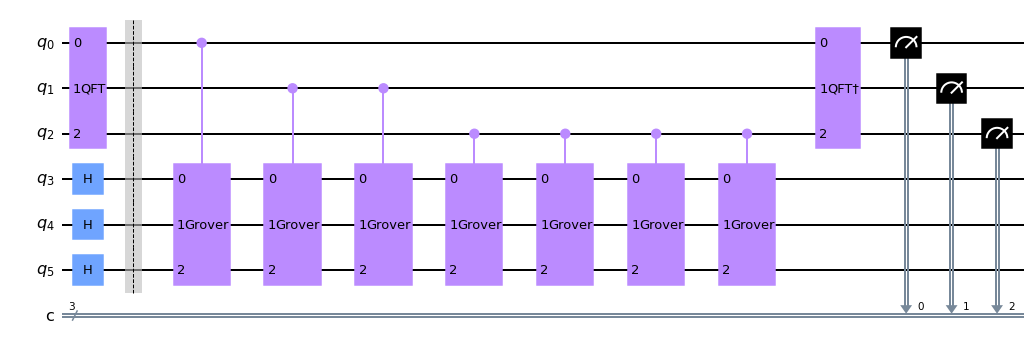

In [353]:
#c is the number of counting qubits for QPE, depends on the amount of accuracy we want 
c = 3   
n = 3   
qc = QuantumCircuit(n+c, c) # Circuit with n+t qubits and t classical

qc.append(qft(c), range(c))

#qc.append(A(n), list(range(c,c+n)))

# The Initial state for the first test case is taken as equal superposition
for qubit in range(c, c+n):
    qc.h(qubit)

    
qc.barrier()
    
# Begin controlled Grover iterations
iterations = 1
for qubit in range(c):
    for i in range(iterations):
        qc.append(cgrit, [qubit] + [*range(c, n+c)])
    iterations *= 2
    
# Do inverse QFT on counting qubits
qc.append(qft_dagger, range(c))

# Measure counting qubits
qc.measure(range(c), range(c))

# Display the circuit
qc.draw('mpl')

### For Oracle 1-

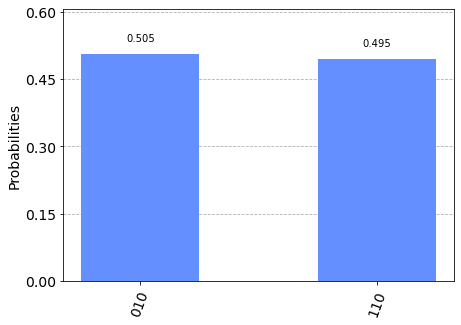

In [347]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, aer_sim)
qobj = assemble(transpiled_qc)
job = aer_sim.run(qobj)
count = job.result().get_counts()
plot_histogram(count)

In [348]:
ans = max(count, key=count.get)
max_meas = int(ans,2)

# max_meas = 12
print("Max : ",max_meas)

theta = (max_meas/(2**c))*math.pi
print("Theta = %.5f" % theta)

N = 2**n
a = math.sin(theta)**2
print("a = %.2f"% a)
M = N * a
print("No. of Solutions = %.1f" % (N-M))

Max :  2
Theta = 0.78540
a = 0.50
No. of Solutions = 4.0


### Correct result, 1,3,5,7

### For Oracle 3 -

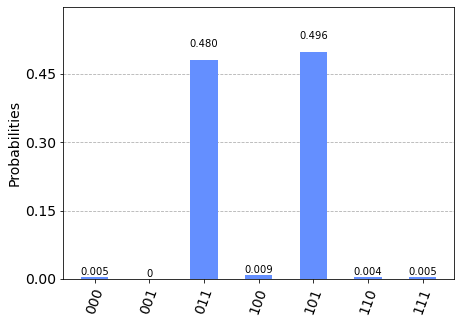

In [340]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, aer_sim)
qobj = assemble(transpiled_qc)
job = aer_sim.run(qobj)
count = job.result().get_counts()
plot_histogram(count)

In [341]:
ans = max(count, key=count.get)
max_meas = int(ans,2)

# max_meas = 12
print("Max : ",max_meas)

theta = (max_meas/(2**c))*math.pi
print("Theta = %.5f" % theta)

N = 2**n
a = math.sin(theta)**2
print("a = %.2f"% a)
M = N * a
print("No. of Solutions = %.1f" % (N-M))

Max :  5
Theta = 1.96350
a = 0.85
No. of Solutions = 1.2


### Problem - though here we have correct result if we round it to integer, i.e. %d in print, other times we have to use %.f only to get coreect results

### For Oracle 2 -

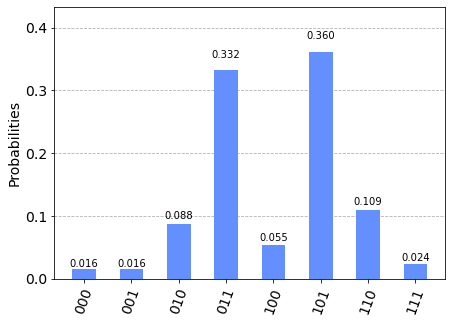

In [354]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, aer_sim)
qobj = assemble(transpiled_qc)
job = aer_sim.run(qobj)
count = job.result().get_counts()
plot_histogram(count)

In [355]:
ans = max(count, key=count.get)
max_meas = int(ans,2)

# max_meas = 12
print("Max : ",max_meas)

theta = (max_meas/(2**c))*math.pi
print("Theta = %.5f" % theta)

N = 2**n
a = math.sin(theta)**2
print("a = %.2f"% a)
M = N * a
print("No. of Solutions = %.1f" % (N-M))

Max :  5
Theta = 1.96350
a = 0.85
No. of Solutions = 1.2


### Here we required no. of solutions as 2, but we don't get it

In [357]:
# If the above things work out, then will start with QRAM integration

In [261]:
def input_add_mem(no_of_address_qubits,no_of_bits_in_memory_cell):
    mc = no_of_bits_in_memory_cell
    a = no_of_address_qubits
    r = 2**a # no.of routing qubits
    m = (2**a)*mc # no. of memory qubits
    bus_yesa = mc+a # no. of classical readout bits required when we also wanna see address 
    bus_noa = mc
    
    qr_a = QuantumRegister(a, "a")
    qr_r = QuantumRegister(r, "r")
    qr_m  = QuantumRegister(m,  "m")
    qr_bus = QuantumRegister(mc, "bus")
    cr = ClassicalRegister(bus_noa, "readout")
    
    qc = QuantumCircuit(qr_a,qr_r,qr_m,qr_bus, cr)
    
    ## you can make the superposition here to query the QRAM 
    
    qc.h(qr_a[0])
    qc.h(qr_a[1])
    
    ## add whatever you wanna add to the memory cells here 
    
    #qc.x(qr_m[0])
    qc.x(qr_m[3])
    qc.x(qr_m[6])
    qc.x(qr_m[7])
    qc.x(qr_m[9])
    qc.x(qr_m[11])
    
    # adding a barrier at the end 
    qc.barrier()
    
    return qc

In [128]:
def QRAM(no_of_address_qubits,no_of_bits_in_memory_cell):
    mc = no_of_bits_in_memory_cell
    a = no_of_address_qubits
    r = 2**a # no.of routing qubits
    m = (2**a)*mc # no. of memory qubits
    bus_noa = mc
    
    qr_a = QuantumRegister(a, "a")
    qr_r = QuantumRegister(r, "r")
    qr_m  = QuantumRegister(m,  "m")
    qr_bus = QuantumRegister(mc, "bus")
    #cr = ClassicalRegister(bus_noa, "readout")
    
    qc = QuantumCircuit(qr_a,qr_r,qr_m,qr_bus)
    

    ## adding the state that will be qureied out and the memory can be stored here
    qc = qc.compose(input_add_mem(a, mc))
### here we will start with the branching
    # there is X gate at the second qubit first
    
    qc.x(qr_r[1])
    # the first branching 
    qc.cx(qr_a[0],qr_r[0])
    qc.cx(qr_r[0],qr_r[1])
    qc.barrier()
    
    # further branchings 
    if a==1:
        ### measuring using measure one
        qc = qc.compose(meas_QRAM_order(a))

        ## finally measuring the bus
        for i in range(0,a):
            qc.measure(qr_a[i],cr[i])
        qc.measure(qr_bus, cr[a])
        return qc
    else:
        # no. of address bits = no. of rouitng iterations
        for i in range(2,a+1):
            for j in range(0,2**(i - 1)):
                qc.ccx(qr_a[i-1], qr_r[j], qr_r[j + 2**(i-1)])
                qc.cx(  qr_r[j + 2**(i-1)], qr_r[j])
            #qc.barrier()

### measuring using measure one
    qc = qc.compose(meas_QRAM_best(a,mc))

    return qc

In [129]:
def binaryToDecimal(binary):
     
    binary1 = binary
    decimal, i, n = 0, 0, 0
    while(binary != 0):
        dec = binary % 10
        decimal = decimal + dec * pow(2, i)
        binary = binary//10
        i += 1
    return decimal 
    
def numConcat(num1, num2): # this should actually do all the additions in the form of strings and then when you finally
                           # take out whatever is stored in the matrix then you should actually convert that to int
  
     # find number of digits in num2
    digits = len(str(num2))
    num2 = str(num2)
    num1 = str(num1)
  
     # add zeroes to the end of num1
#     num1 = num1 * (10**digits)
  
     # add num2 to num1
    num1 += num2
  
    return num1

In [ ]:
def meas_QRAM_best(no_of_address_qubits,no_of_bits_in_memory_cell):
    mc = no_of_bits_in_memory_cell
    a = no_of_address_qubits
    r = 2**a # no.of routing qubits
    m = (2**a)*mc # no. of memory qubits
    bus_yesa = mc+a # no. of classical readout bits required when we also wanna see address 
    bus_noa = mc
    
    qr_a = QuantumRegister(a, "a")
    qr_r = QuantumRegister(r, "r")
    qr_m  = QuantumRegister(m,  "m")
    qr_bus = QuantumRegister(mc, "bus")
    cr = ClassicalRegister(bus_noa, "readout")
    
    qc = QuantumCircuit(qr_a,qr_r,qr_m,qr_bus, cr)
    
### measruing the correct qubit is the main things
    ## here we will make the array which has the ability to couple to the correct qubit it goes like(this is the 
    ## opposite convention of qiskit, qiskit does |q2q1q0> but this basis on q0q1q2)
    ##  1          10         100
    ##  0          00         000
    ##             11         110
    ##             01         010
    ##                        101 .... so on basically half the qubits gets concatinated with 0 and other half with 1

    div = np.array([1,0])
    new_div = ["" for x in range(2**a)]

        
    for i in range(0,a-1): # here i controls the number of times this loop runs, each time we move one level ahead
        div = np.append(div,div)
        dim = len(div)
        for j in range(0,int(dim/2)):
            new_div[j] = numConcat(0,div[j])
        for j in range(int(dim/2),int(dim)):
            new_div[j] = numConcat(1,div[j])
        div = new_div[0:dim]
    
     # for the case of a = 1
    if a == 1:
        new_div = np.array([1,0])
        
        
    # as the original function uses strings we will need to convert shit to integers
    for i in range(0,len(new_div)):
            div[i] = int(new_div[i])
        

        
    # cnverting the array to decimal
    div_decimal = np.zeros(len(div))
    for i in range(0, len(div)):
        div_decimal[i]  = int(binaryToDecimal(div[i])) 
## here is the quantum circuit part of things which do the job



    ## the ordering in which we measure will be same just that it will have to be repeated a couole of times
    ## 1,0,3,2 to 1,1,0,0,3,3,2,2 for case of two 
    final_ord_mat = np.zeros([mc,len(div_decimal)])
    for i in range(len(div_decimal)):
        add = 0
        for j in range(mc):
            final_ord_mat[j,i] = int(div_decimal[i])*int(mc)
            final_ord_mat[j,i] += add
            add = add + 1
    ## now this matrix has to be concatinated onto one another
    final_ord = np.reshape(final_ord_mat,(int(final_ord_mat.size),1), order='F')
    
    
    
    ## now we will also need to input address orderings 
    add_ord = np.zeros(mc*len(div_decimal))
    j_last = 0    
    for i in range(0, len(div_decimal)):
         # the purpose of j_last is is to start from where the last loop stopped in i+j terms
        for j in range( j_last, j_last + mc):
            add_ord[i+j] = i
            j_last = j
            
    ## this one is here for bus orderings 
    bus_ord = np.zeros(0)
    one_ord = range(0, mc)
    for i in range(0,r):
        bus_ord = np.append(bus_ord,one_ord)
            

            
    ## finally adding the ccx gates which will copy out whatever is in the memory cells to the Bus
    for i in range(0, m ):
        qc.ccx(qr_r[int(add_ord[i])], qr_m[int(final_ord[i])], qr_bus[int(bus_ord[i])])
    
    return qc
    